In [1]:
import os
import numpy as np
from collections import defaultdict
import gzip
import pandas as pd

import sys

sys.path.append("../2_train_models")
from data_loading import extract_peaks, extract_observed_profiles
from file_configs import MergedFilesConfig

sys.path.append("../5_modisco")
from modiscolite_utils import load_scores

from plot_utils import get_continuous_cmap
from other_motif_utils import trim_two_motifs_by_thresh, plot_motif_on_ax, compute_per_position_ic
from report_utils import load_modisco_results

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
model_type = "strand_merged_umap"
data_type = "procap"

in_window = 2114
out_window = 1000

In [3]:
new_motifs_info = [["ATF4", "A673", "pos", "profile", 15],
                   ["HNF1A/B", "CACO2", "pos", "profile", 13],
                   ["TEAD", "CACO2", "pos", "profile", 8],
                   ["FOX", "CACO2", "pos", "profile", 31],
                   ["HNF4A/G", "CACO2", "pos", "profile", 16],
                   ["CEBP", "MCF10A", "pos", "profile", 27],
                   ["RFX", "MCF10A", "pos", "profile", 30],
                   ["IRF/STAT", "CALU3", "pos", "counts", 12],
                   ["EWS-FLI", "A673", "pos", "counts", 10],
                   ["SNAI", "A673", "neg", "counts", 1],
                   ["GRHL1", "CACO2", "pos", "counts", 27]]

In [4]:
cell_types = ["K562", "A673", "CACO2", "CALU3", "HUVEC", "MCF10A"]

# need to specify which patterns were which motifs for every expt

motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA",
               "ATF4", "HNF1A/B", "TEAD", "FOX", "HNF4A/G", "CEBP", "RFX", "IRF/STAT", "EWS-FLI",
               "SNAI", "GRHL1"]

In [3]:
motifs_to_patterns = dict()

motifs_to_patterns["K562"]   = [0,1,2,3,4,5,6,7,8,9,13,15,19,21,23,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
motifs_to_patterns["A673"]   = [3,0,5,4,11,7,6,17,13,12,16,20,22,19,np.nan,15,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
motifs_to_patterns["CACO2"]  = [1,0,5,3,6,4,7,14,10,12,11,15,17,25,22,19,13,8,31,16,np.nan,np.nan]
motifs_to_patterns["CALU3"]  = [1,0,3,4,9,6,13,14,10,5,27,18,17,np.nan,np.nan,np.nan,15,np.nan,np.nan,np.nan,np.nan,np.nan]
motifs_to_patterns["HUVEC"]  = [2,0,1,3,8,6,12,16,13,4,15,23,18,np.nan,20,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
motifs_to_patterns["MCF10A"] = [2,0,6,4,8,5,15,16,14,1,11,18,19,21,np.nan,10,np.nan,np.nan,np.nan,np.nan,27,30]

In [5]:
proj_dir = MergedFilesConfig("K562", model_type, data_type).proj_dir
figures_dir = proj_dir + "figures/"

In [6]:
configs = { cell_type : MergedFilesConfig(cell_type, model_type, data_type) for cell_type in cell_types }

In [7]:
import h5py
from collections import defaultdict


def load_motif_pfms_cwms(modisco_results_path, include = None):
    new_f = h5py.File(modisco_results_path, "r")
    
    pfms = defaultdict(lambda : dict())
    cwms = defaultdict(lambda : dict())
    for patterns_group_name in ['pos_patterns', 'neg_patterns']:
        if patterns_group_name in new_f.keys():
            new_patterns_grp = new_f[patterns_group_name]
            
            print(patterns_group_name, " - ", len(new_patterns_grp.keys()), "motifs")
            
            if len(new_patterns_grp.keys()) > 0:
                pattern_names = list(new_patterns_grp.keys())
                pattern_names = sorted(pattern_names, key = lambda name : int(name.split("_")[1]))
                
                for pattern in pattern_names:
                    if include is not None and patterns_group_name in include.keys():
                        if int(pattern.replace("pattern_", "")) not in include[patterns_group_name]:
                            continue
                    
                    pattern_grp = new_patterns_grp[pattern]
                    sequence = pattern_grp["sequence"]
                    contrib_scores = pattern_grp["contrib_scores"]
                    hypothetical_contribs = pattern_grp["hypothetical_contribs"]
                    
                    pfms[patterns_group_name][pattern] = sequence[:]
                    cwms[patterns_group_name][pattern] = contrib_scores[:]
                    
    new_f.close()
    
    return pfms, cwms

pfms = dict()
cwms = dict()

for cell_type in cell_types:
    pfms[cell_type], cwms[cell_type] = load_motif_pfms_cwms(configs[cell_type].modisco_profile_results_path)

pos_patterns  -  43 motifs
neg_patterns  -  3 motifs
pos_patterns  -  43 motifs
pos_patterns  -  43 motifs
pos_patterns  -  36 motifs
pos_patterns  -  31 motifs
pos_patterns  -  36 motifs


In [8]:
pfms_counts = dict()
cwms_counts = dict()

for cell_type in cell_types:
    pfms_counts[cell_type], cwms_counts[cell_type] = load_motif_pfms_cwms(configs[cell_type].modisco_counts_results_path)

pos_patterns  -  33 motifs
neg_patterns  -  16 motifs
pos_patterns  -  24 motifs
neg_patterns  -  2 motifs
pos_patterns  -  41 motifs
neg_patterns  -  1 motifs
pos_patterns  -  24 motifs
neg_patterns  -  1 motifs
pos_patterns  -  26 motifs
pos_patterns  -  39 motifs


In [10]:
import logomaker
from other_motif_utils import trim_two_motifs_by_thresh, compute_per_position_ic

def plot_motif_on_ax(array, ax, ylabel=None):
    assert len(array.shape) == 2 and array.shape[-1] == 4, array.shape
 
    # reformat pwm to what logomaker expects
    df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    # plot motif ("baseline_width=0" removes the y=0 line)
    crp_logo = logomaker.Logo(df, ax=ax, font_name='Arial Rounded', baseline_width=0)
    crp_logo.style_spines(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])

    if ylabel is not None:
        ax.set_title(ylabel, y=1.1, fontsize=6)

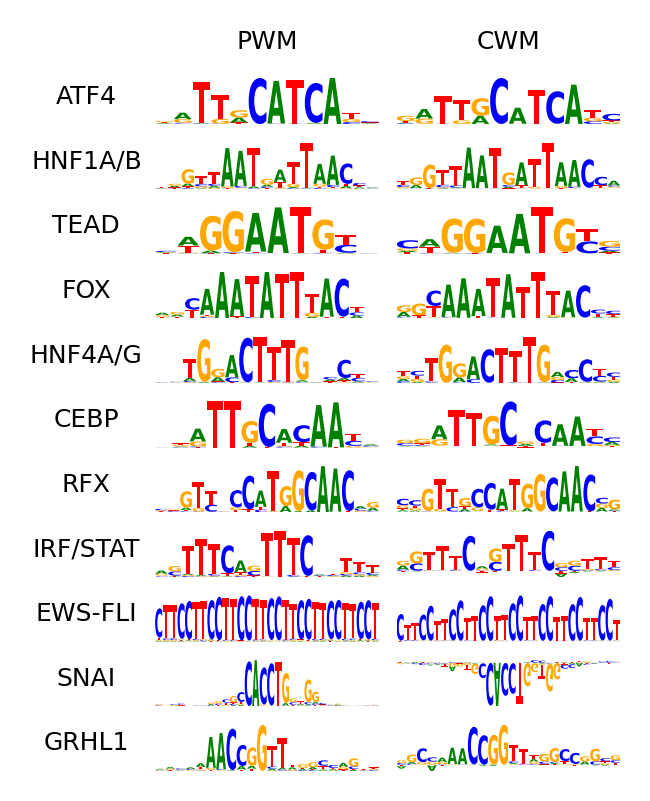

In [13]:
fig, axes = plt.subplots(len(new_motifs_info), 2, figsize=(2, 3), dpi=300)

for ax_i, motif_info in enumerate(new_motifs_info):
    motif_name, cell_type, pattern_type, task, pattern_i = motif_info
    assert task in ["profile", "counts"], task
 
    if task == "counts":
        pfm = pfms_counts[cell_type][pattern_type + "_patterns"]["pattern_" + str(pattern_i)]
        cwm = cwms_counts[cell_type][pattern_type + "_patterns"]["pattern_" + str(pattern_i)]
    else:
        pfm = pfms[cell_type][pattern_type + "_patterns"]["pattern_" + str(pattern_i)]
        cwm = cwms[cell_type][pattern_type + "_patterns"]["pattern_" + str(pattern_i)]
        
    pwm = pfm * compute_per_position_ic(pfm)[:, None]
    pwm_trim, cwm_trim = trim_two_motifs_by_thresh(pwm, cwm)
    
    if ax_i == 0:
        plot_motif_on_ax(pwm_trim, axes[ax_i][0], "PWM")
        plot_motif_on_ax(cwm_trim, axes[ax_i][1], "CWM")
    else:
        plot_motif_on_ax(pwm_trim, axes[ax_i][0])
        plot_motif_on_ax(cwm_trim, axes[ax_i][1])

    axes[ax_i][0].set_ylabel(motif_name, fontsize=6,
                                labelpad=13, rotation=0, y=0.35)
    


plt.subplots_adjust(wspace=0.1 * 0.8, hspace=0.5 * 0.8)

plt.savefig(figures_dir + "celltypes_newmotifs.png",
            bbox_inches = 'tight', pad_inches = 0, dpi = 300)

plt.show()

In [14]:
### Load Motifs

from motif_hits_utils import load_motif_hits
from collections import defaultdict


def remove_duplicate_motif_hits(hits):
    # removes motif hits called twice, across two different peaks
    hits = hits[["chrom", "start", "end", "motif"]]
    return hits.drop_duplicates().reset_index(drop=True)
    

all_motif_hit_counts = defaultdict(lambda : dict())

for cell_type in cell_types:
    hits, _, _ = load_motif_hits(cell_type, model_type, data_type, in_window)
    
    for task in ["profile", "counts"]:
        cleaned_hits = remove_duplicate_motif_hits(hits[task])
        
        raw_hit_counts = np.unique(cleaned_hits["motif"], return_counts=True)
        
        hit_counts = defaultdict(lambda : np.nan)
        for motif_name, num_hits in zip(*raw_hit_counts):
            hit_counts[motif_name] = num_hits
        
        all_motif_hit_counts[cell_type][task] = hit_counts

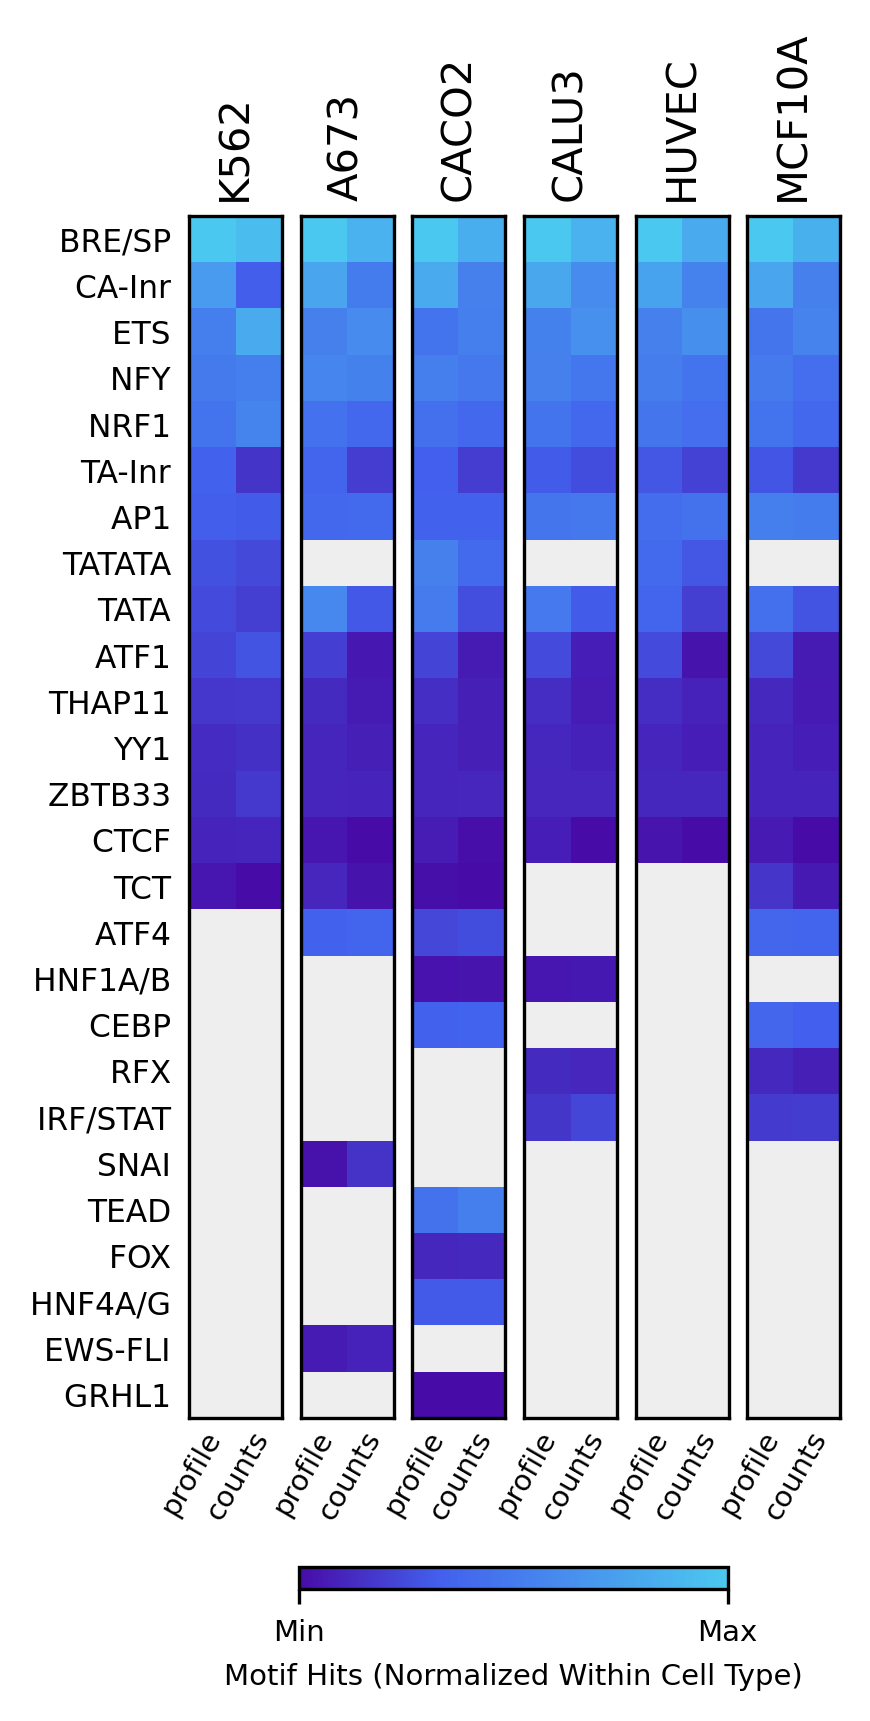

In [16]:
import matplotlib as mpl

def plot_modisco_hits_all_cell_types(all_motif_hit_counts,
                                     motif_names = motif_names,
                                     save_path=None):
    num_motifs = len(motif_names)
    tasks = ["profile", "counts"]
    
    cmap = get_continuous_cmap(["#480CA8", "#4361EE", "#4895EF", "#4CC9F0"])
    cmap.set_bad(color='#EEEEEE')
    
    # 2 = number of tasks
    heatmap_data = np.empty((2, len(cell_types), len(motif_names)))
    
    for task_i, task in enumerate(tasks):
        
        for cell_i, cell_type in enumerate(cell_types):
            hit_counts = all_motif_hit_counts[cell_type][task]

            # this will keep the order of motifs the same
            heatmap_col = [hit_counts[motif_name] for motif_name in motif_names]
            heatmap_data[task_i, cell_i, :] = np.array(heatmap_col)

    heatmap_data = np.swapaxes(heatmap_data, 0, 1)
    
    sort_by = np.copy(heatmap_data[0,0,:])
    for i in range(len(sort_by)):
        if np.isnan(sort_by[i]):
            sort_by[i] = np.sum(~ np.isnan(heatmap_data[:,0,i]))
    
    sort_order = np.argsort(sort_by)[::-1]
    
    heatmap_data = heatmap_data[:,:, sort_order]
    motif_names = np.array(motif_names)[sort_order]
        
    fig, axes = plt.subplots(1, len(cell_types), figsize=(2.8, 0.2 * num_motifs), dpi=300, sharey=True)
    
    for ax_i, cell_type in enumerate(cell_types):
        ax = axes[ax_i]
        ax.imshow(np.sqrt(heatmap_data[ax_i].T),
                  aspect = "auto", cmap=cmap)

        ax.set_xticks(np.arange(len(tasks)) - 0.45, tasks, fontsize=7, rotation=60)
        
        if ax_i == 0:
            ax.set_yticks(np.arange(len(motif_names)), [name + " "  for name in motif_names], fontsize=7.5)

        ax.tick_params(length=0, pad=2)

        ax.set_title(cell_type, fontsize=10, rotation=90)
    
    
    cb_ax = fig.add_axes([0.256, 0.0, 0.51, 0.014])
    
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks=(0,1), orientation="horizontal", cax=cb_ax)
    cbar.set_ticklabels(["Min", "Max"], fontsize=7)
    cbar.set_label("Motif Hits (Normalized Within Cell Type)", fontsize=7)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
        
            
plot_modisco_hits_all_cell_types(all_motif_hit_counts, motif_names,
                                 save_path = figures_dir + "celltypes_modisco_hitcounts.png")